#  Web APIs & NLP Project

# Problem Statement

Our company wants to developed an NLP app which is able to distinguish between news and normal chat. For developing the app, train a classification model which will predict between subreddits WorldNews and CasualConversation for a given text.

## Content
- [Data Description](#Data-Description)
- [Evaluation Metric](#Evaluation-Metric)
- [Executive Summary](#Executive-Summary)
- [Imports](#Imports)
- [Text Cleaning](#Text-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing](#Preprocessing)
    - [Count Vectorizer](#CountVectorizor)
    - [TFIDF Vectorizor](#TFIDF-Vectorizor)
    - [Word2Vec](#Word2Vec)
- [Model Fitting](#Model-Fitting)
    - [Random Forest](#Random-Forest)
    - [Logistic Regression](#Logistic-Regression)
    - [Naive Bayes](#Naive-Bayes)
- [Model Comparison & Selection](#Model-Comparison-&-Selection)
- [Model Interpretability](#Model-Interpretability)
- [Conclusion & Future Recommendation](#Conclusion-&-Future-Recommendation)

# Data Description

|Feature|Type|Description|
|:---:|:---:|:---|
|**title**|*text*| title of a subreddit| 
|**subreddits**|*class*|WorldNews , CasualConversation|

# Evaluation Metric

Our company cares more on predicting worldnews (target) and have low false positive rate (high precision) for the NLP app.

### PR-AUC

Given by our company's priority, we will choose PR-AUC

So how does PR-AUC different compare to ROC AUC?

What is common between ROC AUC and PR AUC is that they both look at prediction scores of classification models and not thresholded class assignments. What is different however is that ROC AUC looks at a true positive rate TPR and false positive rate FPR while PR AUC looks at positive predictive value PPV and true positive rate TPR.

Because of that if we **care more about the positive class, then using PR AUC**, which is more sensitive **to the improvements for the positive class**, is a better choice

After we chosen our PR-AUC score, we will select the best precision/recall threshold based on Fbeta = 0.5

Why Fbeta = 0.5 and how does is it different compare to commonly use F1?


Fbeta = 0.5 gives more weights on precisian. meaning that we will be getting higher precisian and lower recall.
<br>The reason for doing that is that in this problem statement, we care more about decreasing False positive (i.e predicting casual conversation as worldnews). Hence by selecting Fbeta = 0.5 we will increase the precisian rate.

### Baseline of PR AUC

The baseline score for PR- AUC is Number of Positive Class / All Classes

For our dataset, the baseline score is 0.46 or 46% (Refer to Section XX on why 46%). Hence as minimum, our model shall achieve score higher than this.

# Executive Summary

Out of all the classification models built, GaussianNaive Bayes with Word2Vec pre-processing was selected as it achieved the highest PR AUC score of 0.98 on the cross valudation set , outperforming the baseline score of 0.46. Based on intepretation of the model, the model has made sensible prediction on why it classify a text to be a subreddit. 

Hence with this, we will be able to use this model for NLP task in the downstream pipeline.

# Imports

In [47]:
#This Project requires pre-trained word2vec.
#!python -m gensim.downloader --download word2vec-google-news-300

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

from string import punctuation

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import Binarizer, Normalizer

from IPython.display import display
pd.set_option('display.max_colwidth', None)

import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

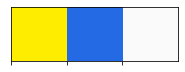

In [49]:
#matplotlib color palette


news = '#FFED00'
casual = '#256AE5'
background_color = "#fafafa"
face_color = '#fafafa'

sns.palplot([news, casual, background_color])

In [50]:
reddit_df = pd.read_csv('reddit.csv')
reddit_df.head()

title  \
0                        Singapore vaccinates 80 percent of population against COVID-19   
1  Friends and family mourn U.S. Marine Corps Sergeant Nicole Gee killed in Afghanistan   
2                     German election campaign heats up as Merkel's conservatives slide   
3                                 UK's Johnson defends Kabul airlift as criticism grows   
4                                      بالصور .. الفنانة درة تطل بالأبيض في أخر صور لها   

   subreddit  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

## Text Cleaning

It seemed that there is none english word in the text. we need to remove it.

In [51]:
#code for checking ASCII character
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [52]:
#removing non english word
reddit_df = reddit_df.loc[reddit_df.title.apply(is_ascii), : ]

In [53]:
#remove punctuation
reddit_df['title'] = reddit_df.title.apply(lambda x: x.translate(x.maketrans('', '', punctuation)))

In [54]:
#tokenize
tokenizer = RegexpTokenizer(r'\w+')

#remove stop word
stop_words = set(stopwords.words('english'))

reddit_df["token"] = reddit_df["title"].apply(tokenizer.tokenize)
reddit_df["token"] = reddit_df["token"].apply(lambda x: [token for token in x if token.lower() not in stop_words])
reddit_df["token"] = reddit_df["token"].apply(lambda x: [token for token in x if not token.isdigit()])
reddit_df

title  \
0                                                     Singapore vaccinates 80 percent of population against COVID19   
1                                Friends and family mourn US Marine Corps Sergeant Nicole Gee killed in Afghanistan   
2                                                  German election campaign heats up as Merkels conservatives slide   
3                                                              UKs Johnson defends Kabul airlift as criticism grows   
5                                                                  Jose Ronaldo back to Man Utd is perfect business   
..                                                                                                              ...   
967                                                                                    How to get over past friends   
968                                                 I clocked in five minutes ago and already got 4 meeting invites   
969          How can I stop thinking about something I dont want to think about and stop feeling inferior to others   
970  Im sitting here trying to entertain myself after Hurricane lda Whats your day to day like We can share stories   
971                                                          Am I weird for not wanting to go to Hawaii in the fall   

              subreddit  \
0             worldnews   
1             worldnews   
2             worldnews   
3             worldnews   
5             worldnews   
..                  ...   
967  CasualConversation   
968  CasualConversation   
969  CasualConversation   
970  CasualConversation   
971  CasualConversation   

                                                                                       token  
0                                      [Singapore, vaccinates, percent, population, COVID19]  
1    [Friends, family, mourn, US, Marine, Corps, Sergeant, Nicole, Gee, killed, Afghanistan]  
2                         [German, election, campaign, heats, Merkels, conservatives, slide]  
3                                  [UKs, Johnson, defends, Kabul, airlift, criticism, grows]  
5                                         [Jose, Ronaldo, back, Man, Utd, perfect, business]  
..                                                                                       ...  
967                                                                     [get, past, friends]  
968                            [clocked, five, minutes, ago, already, got, meeting, invites]  
969          [stop, thinking, something, dont, want, think, stop, feeling, inferior, others]  
970  [Im, sitting, trying, entertain, Hurricane, lda, Whats, day, day, like, share, stories]  
971                                                       [weird, wanting, go, Hawaii, fall]  

[790 rows x 3 columns]

### Top words appearing in each post

In [55]:
words_news = reddit_df.loc[reddit_df.subreddit == 'worldnews', 'token']
words_casual = reddit_df.loc[~(reddit_df.subreddit == 'worldnews'), 'token']

def topword(series, top):
    
    #unpack series to list
    words = list()
    for setences in series:
        words.extend(setences)
    #getting words distribution
    words = FreqDist(word for word in words)
    
    #top 10 words for news
    result = sorted(words.items(), key= lambda x: x[1], reverse=True)[:top]
    return result

words_news = topword(words_news, 20)
words_casual = topword(words_casual, 20)

Text(25.0, -1.0, 'CasualConversation.')

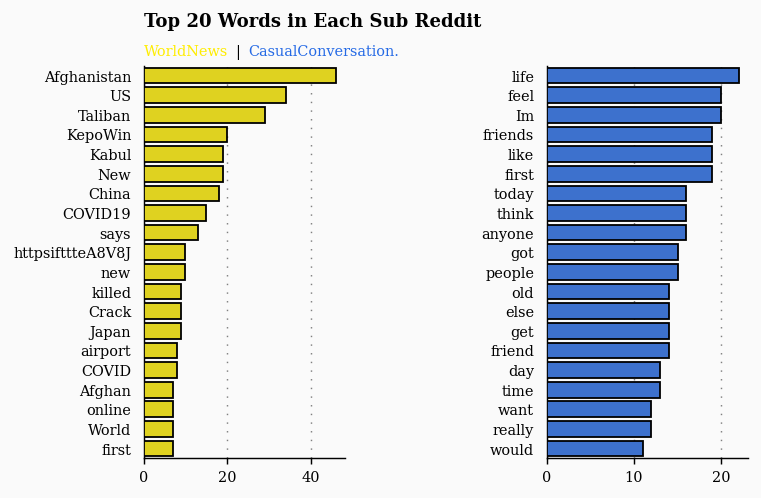

In [56]:
#news
x1 = [value for _ , value in words_news]
y1 = [word for word , _ in words_news]

#casual
x2 = [value for _ , value in words_casual]
y2 = [word for word , _ in words_casual]

#setting structure of figure
fig = plt.figure(figsize=(6,4), dpi=130, facecolor=background_color)
gs = fig.add_gridspec(1,2)
gs.update(wspace=1)



#setting ax1 configuration for news
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(background_color)
ax1.tick_params(axis='y', left=False)
plt.xticks(fontsize=8, fontweight='light', fontfamily='serif')
plt.yticks(fontsize=8, fontweight='light', fontfamily='serif')
ax1.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))

#setting ax2 configuration for casual
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor(background_color)
ax2.tick_params(axis='y', left=False)
plt.xticks(fontsize=8, fontweight='light', fontfamily='serif')
plt.yticks(fontsize=8, fontweight='light', fontfamily='serif')
ax2.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))

for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    
#plotting    
sns.barplot(x=x1, y=y1, orient='h', ax=ax1, color=news, ec='black', zorder=3)
sns.barplot(x=x2, y=y2, orient='h', ax=ax2, color=casual, ec='black',zorder=3)


#title
Xstart, Xend = ax1.get_xlim()
Ystart, Yend = ax1.get_ylim()
ax1.text(Xstart, Yend+(Yend*4), 'Top 20 Words in Each Sub Reddit', fontsize=10, fontweight='bold', fontfamily='serif')
ax1.text(Xstart, Yend+(Yend*1), 'WorldNews', fontsize=8, fontweight='light', fontfamily='serif', color = news)
ax1.text(Xstart+22, Yend+(Yend*1), '|', fontsize=8, fontweight='light', fontfamily='serif', color = 'black')
ax1.text(Xstart+25, Yend+(Yend*1), 'CasualConversation.', fontsize=8, fontweight='light', fontfamily='serif', color = casual)

It seemed that there are some funny words like KepoWin and url link 'httpsifttteA8V8J', we will investigate what it is and remove it.

Search in our dataset returns that KepoWin is an advsertisement spam bot and shall not be included in worldnews . Hence we will removed all post contains 'KepoWin'

In [57]:
#post contains KepoWin
reddit_df["title"][reddit_df["title"].str.find('KepoWin') != -1]

18                       Jam Berapa FF Max Rilis di Indonesia  KepoWin
20                                Samehadaku Tidak Bisa Akses  KepoWin
63                      Nonton One Piece Episode 990 Sub Indo  KepoWin
64            Nonton Lovers of the Red Sky Episode 2 Sub Indo  KepoWin
65     Nonton Boruto Episode 215 Gomunime Samehadaku Sub Indo  KepoWin
69                                Daftar HP Diblokir WhatsApp  KepoWin
75                Cannot Marshal Response Payload Artinya Apa  KepoWin
81                                      Sianida Telegram 2021  KepoWin
94                                         Manfaat Bermain FF  KepoWin
467                   Kode Redeem PUBG Mobile 31 Agustus 2021  KepoWin
470                Kode Redeem Genshin Impact 31 Agustus 2021  KepoWin
473                Kode Redeem Mobile Legends 31 Agustus 2021  KepoWin
474                     Kode Redeem Free Fire 31 Agustus 2021  KepoWin
476                        Cara Setting Router Tenda Lewat HP  KepoWin
478   

In [58]:
#index for KepoWin
idx_to_drop = reddit_df["title"][reddit_df["title"].str.find('KepoWin') != -1].index

reddit_df = reddit_df.drop(idx_to_drop)
reddit_df["title"][reddit_df["title"].str.find('KepoWin') != -1].index

Int64Index([], dtype='int64')

In [59]:
#post contains https
reddit_df["title"][reddit_df["title"].str.find('https') != -1]

40                                  Veteran Afghan Strongmen to Form New Front for Negotiating With Taliban httpsifttteA8V8J
56                                            Israel Bombs Hamas Sites in Gaza Over Fire Balloons  Military httpsifttteA8V8J
206            New California wildfire forces evacuations and grows to 1200 acres in less than 6 hours usa httpsifttt2KUz4QH
254                                              West Virginia Residents Can Have Land Designated Wild Yard httpsifttteA8V8J
271                                                  Indias COVID Vaccine Supply Jumps Raising Export Hopes httpsifttteA8V8J
285                                            Ida Knocks Out New Orleans Power on Deadly Path Through Gulf httpsifttteA8V8J
426                                    Britain Denies Pushing to Leave Kabul Airport Gate Open Before Blast httpsifttteA8V8J
436    DIRECCION MUNDIAL FAJAS FITNESS MOLDELADORAS ORTOPEDICAS POSTOPERATORIAS httpswwwfacebookcomgroupsfajastodotipolaamdp


From above, most of the documents is a valid new post except for index 436, 468, 485,667 which seemed like a spam.

1. We will remove documents for index (436, 468, 485,667)
2. and removed the url words for the rest.

In [60]:
#dropping rows containing spam
reddit_df = reddit_df.drop([436, 468,485,667])

#remove the words starts with https 
reddit_df["title"] = reddit_df["title"].str.replace('https[\w]+', "", regex=True)

In [61]:
#retokenize the word since we have replaced the https in 'title' column
reddit_df["token"] = reddit_df["title"].apply(tokenizer.tokenize)
reddit_df["token"] = reddit_df["token"].apply(lambda x: [token for token in x if token.lower() not in stop_words])
reddit_df["token"] = reddit_df["token"].apply(lambda x: [token for token in x if not token.isdigit()])
reddit_df

title  \
0                                                     Singapore vaccinates 80 percent of population against COVID19   
1                                Friends and family mourn US Marine Corps Sergeant Nicole Gee killed in Afghanistan   
2                                                  German election campaign heats up as Merkels conservatives slide   
3                                                              UKs Johnson defends Kabul airlift as criticism grows   
5                                                                  Jose Ronaldo back to Man Utd is perfect business   
..                                                                                                              ...   
967                                                                                    How to get over past friends   
968                                                 I clocked in five minutes ago and already got 4 meeting invites   
969          How can I stop thinking about something I dont want to think about and stop feeling inferior to others   
970  Im sitting here trying to entertain myself after Hurricane lda Whats your day to day like We can share stories   
971                                                          Am I weird for not wanting to go to Hawaii in the fall   

              subreddit  \
0             worldnews   
1             worldnews   
2             worldnews   
3             worldnews   
5             worldnews   
..                  ...   
967  CasualConversation   
968  CasualConversation   
969  CasualConversation   
970  CasualConversation   
971  CasualConversation   

                                                                                       token  
0                                      [Singapore, vaccinates, percent, population, COVID19]  
1    [Friends, family, mourn, US, Marine, Corps, Sergeant, Nicole, Gee, killed, Afghanistan]  
2                         [German, election, campaign, heats, Merkels, conservatives, slide]  
3                                  [UKs, Johnson, defends, Kabul, airlift, criticism, grows]  
5                                         [Jose, Ronaldo, back, Man, Utd, perfect, business]  
..                                                                                       ...  
967                                                                     [get, past, friends]  
968                            [clocked, five, minutes, ago, already, got, meeting, invites]  
969          [stop, thinking, something, dont, want, think, stop, feeling, inferior, others]  
970  [Im, sitting, trying, entertain, Hurricane, lda, Whats, day, day, like, share, stories]  
971                                                       [weird, wanting, go, Hawaii, fall]  

[766 rows x 3 columns]

In [62]:
#final check to ensure we have remove 'KepoWin'
print(len(reddit_df["title"][reddit_df["title"].str.find('KepoWin') != -1]))

#final check to ensure we have remove 'https'
print(len(reddit_df["title"][reddit_df["title"].str.find('https') != -1]))

0
0


## How balance are our data after cleaning?

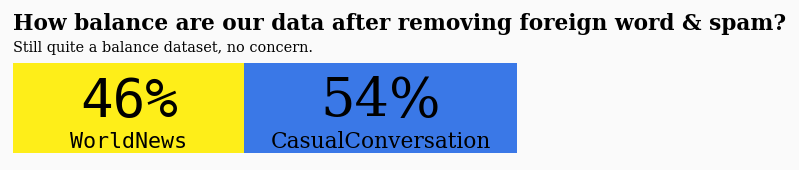

In [63]:
df_balance = reddit_df.subreddit.value_counts(normalize=True)

#setting structural for matplotlib
fig = plt.figure(figsize=(5, 1), dpi=130, facecolor=background_color)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_facecolor(background_color)

#setting adding barh
ax.barh(1, df_balance.worldnews, color=news, alpha=0.9)
ax.barh(1, df_balance.CasualConversation, left=df_balance.worldnews, color=casual, alpha=0.9)

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

#add % for worldnews
ax.annotate(f"{int(round(df_balance.worldnews,2)*100)}%", 
                    xy=(df_balance.worldnews/2, 1.05),
                   va = 'center', ha='center',fontsize=30, fontweight='light', fontfamily='monospace',
                    color='black')

ax.annotate("WorldNews", 
               xy=(df_balance.worldnews/2, 0.7),
               va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='monospace',
               color='black')

#add % for casualconversation  
ax.annotate(f"{int(round(df_balance.CasualConversation,2)*100)}%", 
                    xy=(df_balance.worldnews + df_balance.CasualConversation/2, 1.05 ),
                   va = 'center', ha='center',fontsize=30, fontweight='light', fontfamily='serif',
                    color='black')

ax.annotate("CasualConversation", 
               xy=(df_balance.worldnews + df_balance.CasualConversation/2, 0.7),
               va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
               color='black')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)



#Title
ax.text(0,1.7,'How balance are our data after removing foreign word & spam?',fontsize=12, fontweight='bold',fontfamily='serif')
ax.text(0,1.5,"Still quite a balance dataset, no concern.",fontsize=8, fontweight='light',fontfamily='serif')
plt.show()

# Exploratory Data Analysis

### First, we will investigate if there is a difference in length of documents (number of words) betewen each subreddits

In [64]:
#obtain the length of each document(number of characters per row)
reddit_df['Length'] = reddit_df.title.str.len()

# length for worldnews
length_news = reddit_df.loc[reddit_df.subreddit == 'worldnews', 'Length']

# length for casual
length_casual = reddit_df.loc[~(reddit_df.subreddit == 'worldnews'), 'Length']

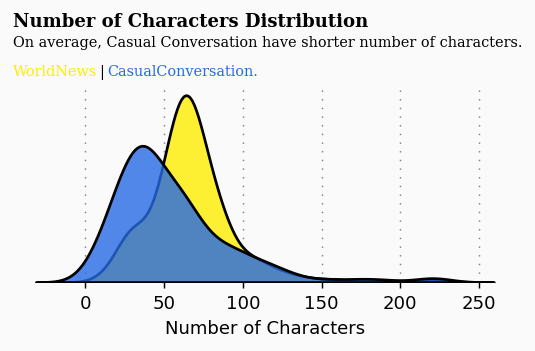

In [65]:
#setting structure of figure
fig = plt.figure(figsize=(5,2), dpi=130, facecolor=background_color)
fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])
ax.set_yticks([])
ax.set_facecolor(background_color)
ax.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax.set_xlabel('Number of Characters')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

#plotting worldnews kde
sns.kdeplot(length_news ,ax=ax, color=news,ec='black', 
            shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)

#plotting casual conversation kde
sns.kdeplot(length_casual ,ax=ax, color=casual,ec='black', 
            shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)

#adding text description & legend
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()
ax.text(Xstart, Yend+(Yend*0.30), 'Number of Characters Distribution', fontsize=10, fontweight='bold', fontfamily='serif')
ax.text(Xstart, Yend+(Yend*0.20), 'On average, Casual Conversation have shorter number of characters.', fontsize=8, fontweight='light', fontfamily='serif')
ax.text(Xstart, Yend+(Yend*0.05), 'WorldNews', fontsize=8, fontweight='light', fontfamily='serif', color = news)
ax.text(Xstart+55, Yend+(Yend*0.05), '|', fontsize=8, fontweight='light', fontfamily='serif', color = 'black')
ax.text(Xstart+60, Yend+(Yend*0.05), 'CasualConversation.', fontsize=8, fontweight='light', fontfamily='serif', color = casual);

### What about number of words?

In [66]:
#number of words
reddit_df['words'] = reddit_df['token'].str.len()

#for worldnews
words_news = reddit_df.loc[reddit_df.subreddit == 'worldnews', 'words']

#for casual
words_casual = reddit_df.loc[~(reddit_df.subreddit == 'worldnews'), 'words']

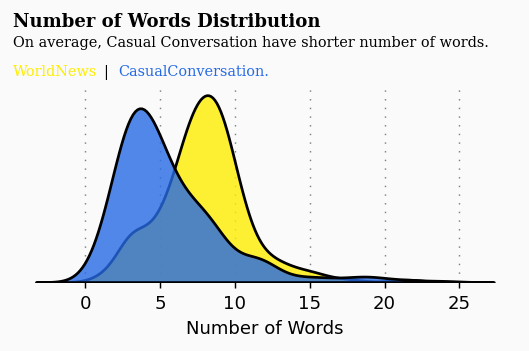

In [67]:
#setting structure of figure
fig = plt.figure(figsize=(5,2), dpi=130, facecolor=background_color)
fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0])
ax.set_yticks([])
ax.set_facecolor(background_color)
ax.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax.set_xlabel('Number of Words')

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

#plotting worldnews kde
sns.kdeplot(words_news ,ax=ax, color=news,ec='black', 
            shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)

#plotting casual conversation kde
sns.kdeplot(words_casual ,ax=ax, color=casual,ec='black', 
            shade=True, linewidth=1.5, alpha=0.8, zorder=3, legend=False)

#adding text description & legend
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()
ax.text(Xstart, Yend+(Yend*0.30), 'Number of Words Distribution', fontsize=10, fontweight='bold', fontfamily='serif')
ax.text(Xstart, Yend+(Yend*0.20), 'On average, Casual Conversation have shorter number of words.', fontsize=8, fontweight='light', fontfamily='serif')
ax.text(Xstart, Yend+(Yend*0.05), 'WorldNews', fontsize=8, fontweight='light', fontfamily='serif', color = news)
ax.text(Xstart+6, Yend+(Yend*0.05), '|', fontsize=8, fontweight='light', fontfamily='serif', color = 'black')
ax.text(Xstart+7, Yend+(Yend*0.05), 'CasualConversation.', fontsize=8, fontweight='light', fontfamily='serif', color = casual);

# Preprocessing

Train test split to ensure we do not have data leakage

In [68]:
X = reddit_df['title']
y = reddit_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In this project, we investigate below methods of pre-processing our text.

1. Bags of Word (TFIDF, CountVect)
2. word2vec


## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is an unsupervised machine learning technique that attempts to derive a set of low-dimensional set of features from a much larger set while still preserving as much variance as possible. The two main applications of PCA are

1. Dimension Reduction
2. Clustering

For this section we will be focusing on the visualization part of clustering to find if there is a distinct different cluster across the principal components.

In [69]:
#function for plotting pca
def plotpca(data, n_components=2, scale=True):

    fig = plt.figure(figsize=(n_components*2, n_components*2), dpi=130, facecolor=background_color)
    gs = fig.add_gridspec(n_components, n_components)

    #figure background
    for row in range(n_components):
        for col in range(row + 1):
            globals()[f'ax{row}{col}'] = fig.add_subplot(gs[row, col]) 
            globals()[f'ax{row}{col}'].set_facecolor(background_color)  
        globals()[f'ax{row}{col}'].text(0.25, 0.4,f'PC{row+1}',fontsize=20, fontweight='light',fontfamily='sans-serif')
        globals()[f'ax{row}{col}'].set_xticks([])
        globals()[f'ax{row}{col}'].set_yticks([])
        for s in ["bottom","left","top","right"]:
            globals()[f'ax{row}{col}'].spines[s].set_visible(False)
    
    if scale:
        data = Normalizer().fit_transform(data)
    
    #calculating PCA    
    pca = PCA(n_components=n_components, svd_solver = 'full')
    
    pca_scores = pca.fit_transform(data)

    #plotting PCA
    for row in range(1, n_components):
        for col in range(row):
            sns.scatterplot(x=pca_scores[:,col], y=pca_scores[:, row], ax = globals()[f'ax{row}{col}'], 
                            hue=y_train, hue_order=y_train.unique().tolist(), palette=[news, casual],
                            alpha=0.9, s=10, ec='k')
            globals()[f'ax{row}{col}'].legend().set_visible(False)
            globals()[f'ax{row}{col}'].tick_params(axis='both', which='major', labelsize=6)
            globals()[f'ax{row}{col}'].tick_params(axis='both', which='both',length=0)
            for s in ["top","right"]:
                globals()[f'ax{row}{col}'].spines[s].set_visible(False)
    return fig

## CountVectorizor

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text for machine learning model fitting.
CountVectorizor doesnt take account of the semantic of words.


1. Don't, I hate it.
2. I don't hate it.

Above sentence which have totally different meaning appears the same for countvectorizer

In [70]:
countvec = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_count = countvec.fit_transform(X_train)

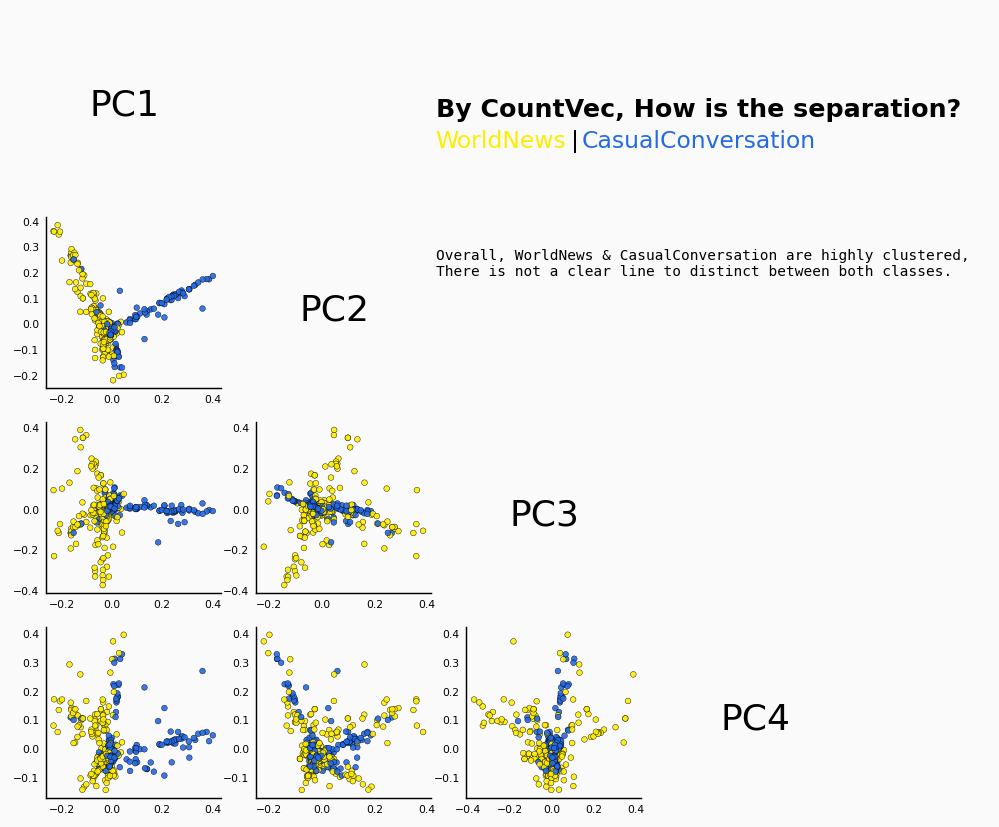

In [71]:
fig = plotpca(X_train_count.toarray(), n_components=4)

fig.text(0.5,0.78,"By CountVec, How is the separation?",fontsize=14,fontfamily='sans-serif',fontweight='bold')
fig.text(0.5,0.75,'WorldNews',fontsize=13,fontfamily='sans-serif',color=news)
fig.text(0.63,0.75,'|',fontsize=13,fontfamily='sans-serif',color='black')
fig.text(0.64,0.75,'CasualConversation',fontsize=13,fontfamily='sans-serif',color=casual)

fig.text(0.5, 0.58,"""

Overall, WorldNews & CasualConversation are highly clustered,  
There is not a clear line to distinct between both classes.


""",fontsize=8,fontfamily='monospace', color='black');

## TFIDF Vectorizor

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. The concept of TFIDF is similar to CountVectorizer using Bags of Words except that it makes words that appear in multiple documents ( in this case rows of datasets) insignificant.

In [72]:
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 2))

In [73]:
X_train_count = tfidf.fit_transform(X_train)

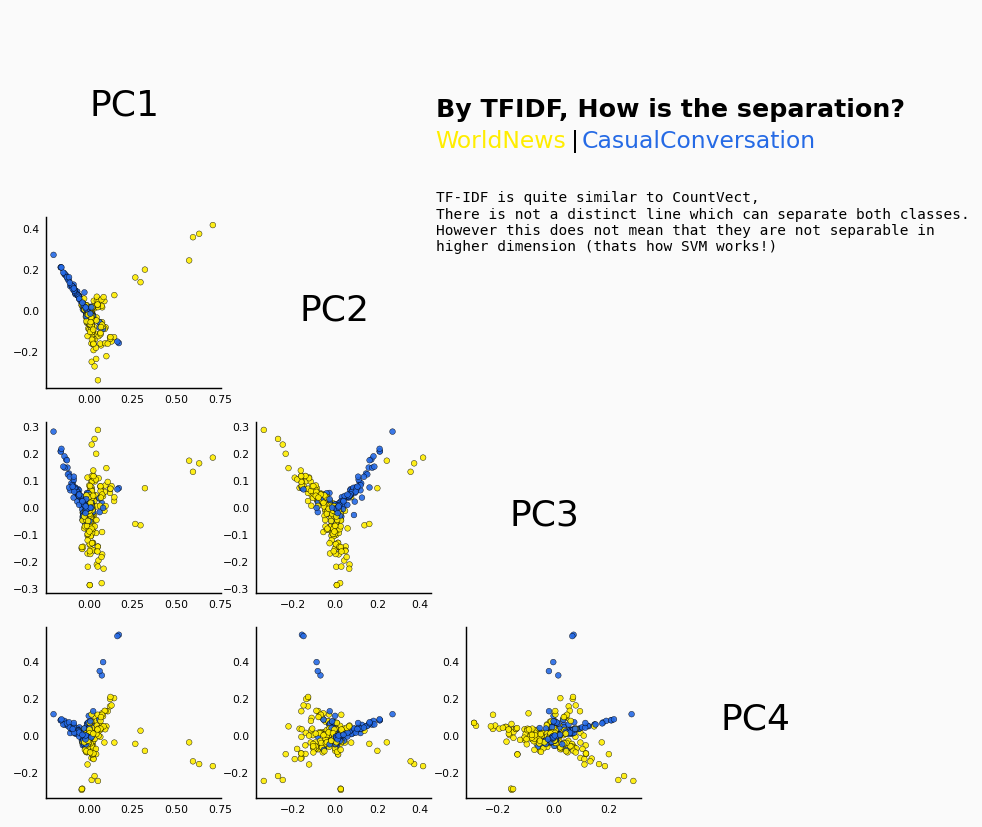

In [74]:
fig = plotpca(X_train_count.toarray(), n_components=4)
            
fig.text(0.5,0.78,"By TFIDF, How is the separation?",fontsize=14,fontfamily='sans-serif',fontweight='bold')
fig.text(0.5,0.75,'WorldNews',fontsize=13,fontfamily='sans-serif',color=news)
fig.text(0.63,0.75,'|',fontsize=13,fontfamily='sans-serif',color='black')
fig.text(0.64,0.75,'CasualConversation',fontsize=13,fontfamily='sans-serif',color=casual)

fig.text(0.5, 0.62,"""

TF-IDF is quite similar to CountVect,
There is not a distinct line which can separate both classes.
However this does not mean that they are not separable in
higher dimension (thats how SVM works!)

""",fontsize=8,fontfamily='monospace',color='black');

## Word2Vec

In [75]:
# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [76]:
def get_average_word2vec(tokens_list, vector, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
       
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    
    return averaged

In [77]:
#vectorize the tokens
vectorized = reddit_df.token.apply(lambda x: get_average_word2vec(x, word2vec))

In [78]:
vec = list()
for x in vectorized:
    vec.append(list(x))
vectorized = np.array(vec)

In [79]:
#train test split
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(vectorized, y, test_size=0.2, random_state=0, stratify=y)

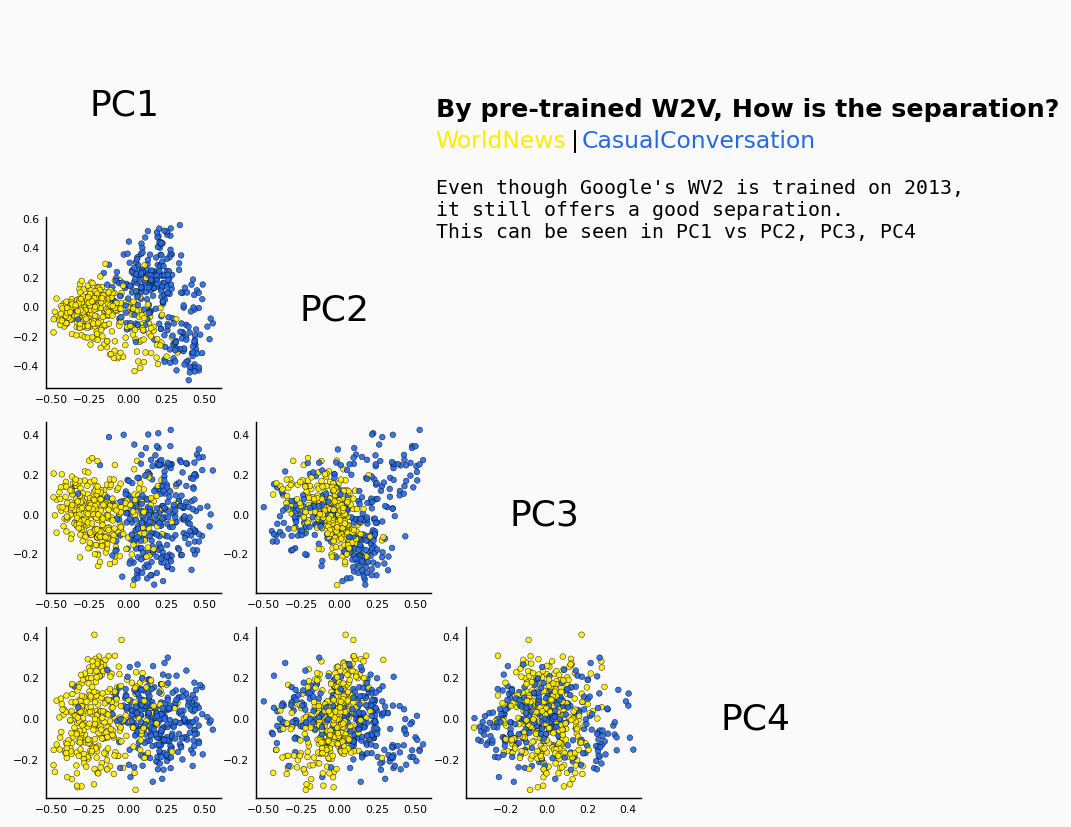

In [80]:
fig = plotpca(X_train_vec, n_components=4)

fig.text(0.5,0.78,"By pre-trained W2V, How is the separation?",fontsize=14,fontfamily='sans-serif',fontweight='bold')
fig.text(0.5,0.75,'WorldNews',fontsize=13,fontfamily='sans-serif',color=news)
fig.text(0.63,0.75,'|',fontsize=13,fontfamily='sans-serif',color='black')
fig.text(0.64,0.75,'CasualConversation',fontsize=13,fontfamily='sans-serif',color=casual)

fig.text(0.5, 0.60,"""

Even though Google's WV2 is trained on 2013,
it still offers a good separation.
This can be seen in PC1 vs PC2, PC3, PC4


""",fontsize=11,fontfamily='monospace', color='black');

### Does using Word2Vec trained 2013 have any issue for problem that is affected by time?

News are extremely dynamic, we do not expect recent news eg: Covid to appear in the pre-train model. Lets see how many words are not captured by google pre-train model.

In [81]:
total_token = reddit_df.token.str.len().sum()
total_token

5104

### Getting number of missing Words

In [82]:
def missingword(series, vector):
    missing = list()
    for token in series:
        if token not in vector:
            missing.append(token)
    return missing

In [83]:
#number of words missing
reddit_df['missing_word2vec'] = reddit_df.token.apply(lambda x: missingword(x, word2vec))
news_missing = reddit_df.loc[reddit_df.subreddit == 'worldnews', 'missing_word2vec'].str.len().sum()
casual_missing = reddit_df.loc[reddit_df.subreddit == 'CasualConversation', 'missing_word2vec'].str.len().sum()
total_missing = news_missing + casual_missing

### Getting distribution of missing Words

In [84]:
news_word_series = reddit_df.loc[reddit_df.subreddit == 'worldnews', 'missing_word2vec']
casual_word_series = reddit_df.loc[reddit_df.subreddit == 'CasualConversation', 'missing_word2vec']

In [85]:
#getting the distribution of missing words
def word_distribution(series, top=5):
    
    #unpack all missing words in worldnews
    words = list()
    for setences in series:
        words.extend(setences)
    
    words = FreqDist(word for word in words)
    result = sorted(words.items(), key= lambda x: x[1], reverse=True)[:top]
    
    #to unpack words and values
    def helper(list_):
        words = []
        values = []
        for word, value in list_:
            words.append(word)
            values.append(value)
        return words, values
    
    return helper(result)


In [86]:
news_words, news_value = word_distribution(news_word_series)
casual_words, casual_value = word_distribution(casual_word_series)

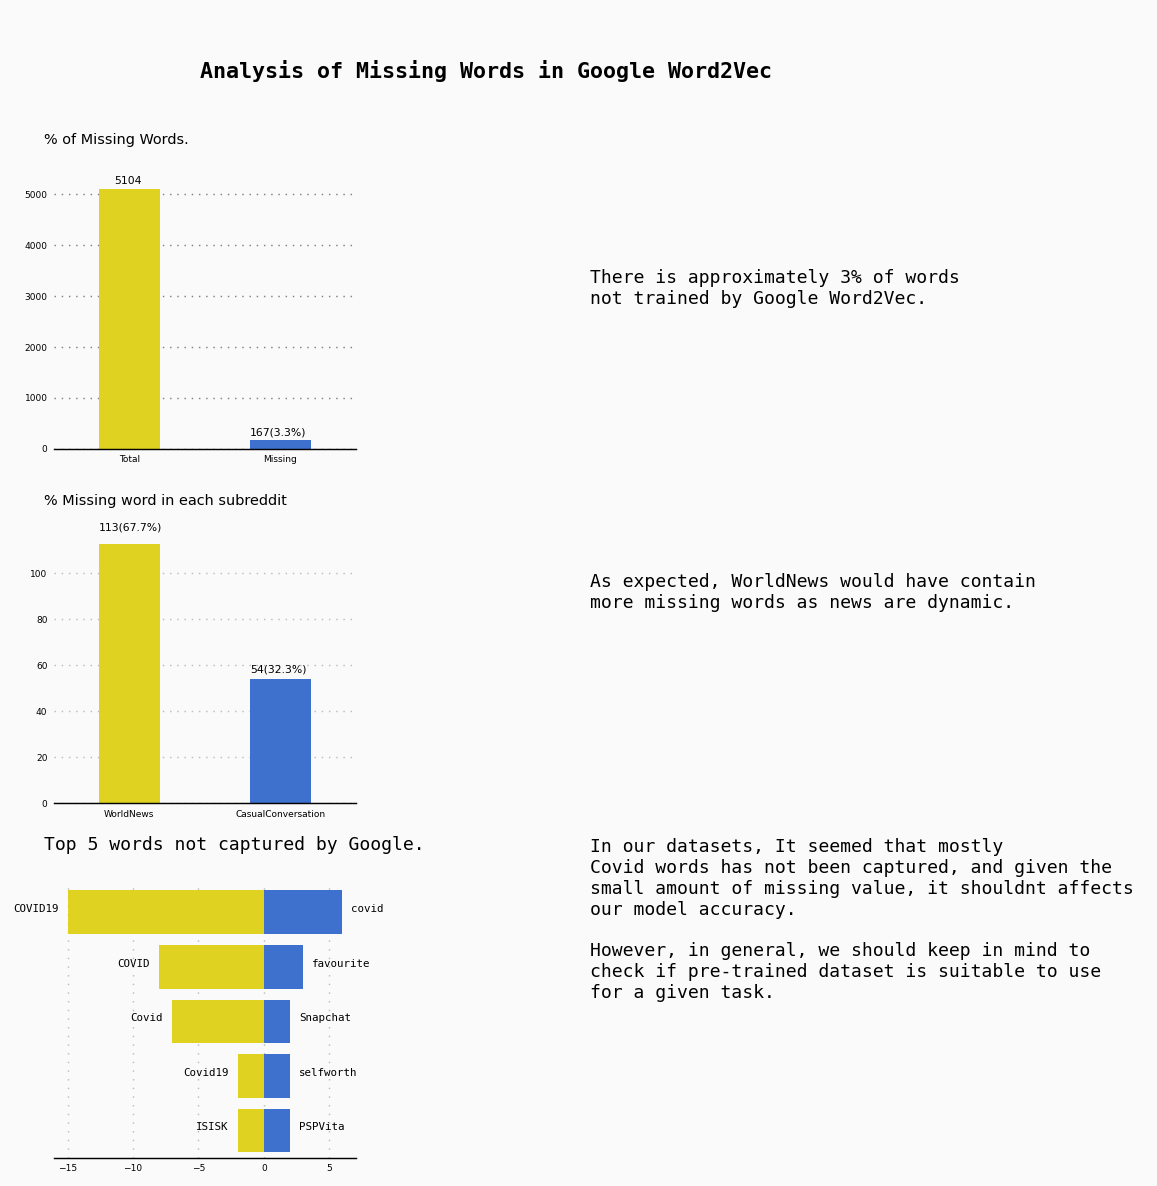

In [87]:
nrows = 3
ncols = 1
xcoor = np.arange(5)

fig = plt.figure(figsize=(3, 10), dpi=130, facecolor=background_color)
gs = fig.add_gridspec(nrows, ncols)
gs.update(wspace=0.3, hspace=0.3)
#setting matplotlib structure
for row in range(nrows):
    for col in range(ncols):
        globals()[f'ax{row}{col}'] = fig.add_subplot(gs[row, col])
        globals()[f'ax{row}{col}'].set_facecolor(background_color)
        globals()[f'ax{row}{col}'].tick_params(axis='both', which='major', length=0, labelsize=5)
        for s in ['top', 'left', 'right']:
            globals()[f'ax{row}{col}'].spines[s].set_visible(False)
            
        
        # plotting first graph
        if row == 0:
            sns.barplot(x=['Total', 'Missing'], y=[total_token, casual_missing + news_missing], ax=globals()[f'ax{row}{col}'],
                       palette=[news, casual], alpha=1)
            globals()[f'ax{row}{col}'].grid(which='major', color='gray', linestyle=':', axis='y',  dashes=(1,4))
            globals()[f'ax{row}{col}'].set_axisbelow(True)
                    
            patches = globals()[f'ax{row}{col}'].patches
            
            #resize bar width
            for idx, r in enumerate(patches):
                x = r.get_x()
                y = r.get_y() + r.get_height()
                current_width = r.get_width()
                centre = x + current_width/2
                r.set_width(current_width/2)
                r.set_x(centre - current_width/4)
                
                if idx == 0:
                    globals()[f'ax{row}{col}'].annotate(f'{total_token}', xy=(centre - current_width/8 , y + 100), size=6)
                    
                if idx == 1:
                    globals()[f'ax{row}{col}'].annotate(f'{total_missing}({total_missing/total_token:.1%})',
                                                        xy=(centre - current_width/4 , y + 100), size=6)

        
        #plotting second graph
        if row == 1:
           
            
            sns.barplot(x=['WorldNews', 'CasualConversation'], y=[news_missing, casual_missing], ax=globals()[f'ax{row}{col}'],
                       palette=[news, casual], alpha=1)
            
            globals()[f'ax{row}{col}'].grid(color='gray', linestyle=':', axis='y',  dashes=(1,4), alpha=0.5)
            globals()[f'ax{row}{col}'].set_axisbelow(True)
            
            
            
 
            patches = globals()[f'ax{row}{col}'].patches
            
            #resize bar width
            for idx, r in enumerate(patches):
                x = r.get_x()
                y = r.get_y() + r.get_height()
                current_width = r.get_width()
                centre = x + current_width/2
                r.set_width(current_width/2)
                r.set_x(centre - current_width/4)
                new_width = r.get_width()
         
                if idx == 1:
                    globals()[f'ax{row}{col}'].annotate(f'{casual_missing}({casual_missing/total_missing:.1%})', 
                                                        xy=(x + new_width/2 , 1.05*y), size=6)
                    
                if idx == 0:
                    globals()[f'ax{row}{col}'].annotate(f'{news_missing}({news_missing/total_missing:.1%})',
                                                        xy=(x + new_width/2 , 1.05*y), size=6)
            
        #plotting third graph
        if row == 2:
            
            sns.barplot(x=-1*np.array(news_value), y=xcoor, orient='h', ax=globals()[f'ax{row}{col}'], color=news)
            sns.barplot(x=casual_value, y=xcoor, orient='h', ax=globals()[f'ax{row}{col}'], color=casual)
            globals()[f'ax{row}{col}'].set_yticks([])
            globals()[f'ax{row}{col}'].grid(color='gray', linestyle=':', axis='x',  dashes=(1,5), alpha=0.5)
            globals()[f'ax{row}{col}'].set_axisbelow(True)
            
            patches = globals()[f'ax{row}{col}'].patches
            
            idx1 = 0
            idx2 = 0
            for r in patches:
                
                
                if r.get_width() < 0: #worldnews
                    
                    
                    #starting point
                    x = r.get_x()
                    y = r.get_y()
                    
                    #width & height of bar
                    width = r.get_width()
                    height = r.get_height()
                    
                    #anchoring point of annotation
                    
                    anchor = (x + width,  y + height / 2)
                    globals()[f'ax{row}{col}'].annotate(news_words[idx1], xy = anchor, xytext = (-5, 0),
                                                       textcoords='offset points', size= 6,
                                                       fontfamily='monospace',fontweight='light',  ha='right')
                    idx1 += 1
                                                             
                else: #casual
                    x = r.get_x()
                    y = r.get_y()
                    
                    #width & height of bar
                    width = r.get_width()
                    height = r.get_height()
                    
                    #anchoring point of annotation
                    
                    anchor = (x + width,  y + height / 2)
                    globals()[f'ax{row}{col}'].annotate(casual_words[idx2], xy= anchor, size=6,
                                                        xytext = (5, 0), textcoords='offset points',
                                                       fontfamily='monospace',fontweight='light')
                    idx2 += 1                                                        

# add text for 1st graph
fig.text(0.1 ,0.88, """

% of Missing Words.

""", fontsize=8,fontfamily='sans-serif',fontweight='light' )   


fig.text(1.5 ,0.75, """

There is approximately 3% of words 
not trained by Google Word2Vec.

""", fontsize=10,fontfamily='monospace',fontweight='light' )        
        


# add text for 2nd graph        
fig.text(0.1 ,0.59, """
% Missing word in each subreddit


""", fontsize=8,fontfamily='sans-serif',fontweight='light' )

fig.text(1.5 ,0.50, """
As expected, WorldNews would have contain 
more missing words as news are dynamic.


""", fontsize=10,fontfamily='monospace',fontweight='light' )


# add text for 3nd graph        
fig.text(0.1 ,0.33, """
Top 5 words not captured by Google.

""", fontsize=10,fontfamily='monospace',fontweight='light' );

fig.text(1.5 ,0.20, """

In our datasets, It seemed that mostly 
Covid words has not been captured, and given the  
small amount of missing value, it shouldnt affects 
our model accuracy.

However, in general, we should keep in mind to 
check if pre-trained dataset is suitable to use 
for a given task.


""", fontsize=10,fontfamily='monospace',fontweight='light' );

#add title
fig.text(0.5 ,0.92, """

Analysis of Missing Words in Google Word2Vec

""", fontsize=12,fontfamily='monospace',fontweight='bold' ) ;   

# Model Fitting

In [88]:
pr_score = make_scorer(average_precision_score, pos_label='worldnews', needs_threshold=True)

In [89]:
#model that returns the best mode, and test score, it also shows the best hyperparameter and mean validation score
def model_fitting(pipe, params, X_train, y_train, X_test, y_test):
    
    #finding the best parameter
    grid = GridSearchCV(pipe, params, scoring=pr_score, cv=10)
    grid.fit(X_train, y_train);
    frame = pd.DataFrame(grid.cv_results_).nsmallest(1, 'rank_test_score')[['params', 'mean_test_score']]      
    display(frame.rename({'mean_test_score': 'mean_validation_score'}, axis=1))
    
    return grid.best_estimator_, grid.best_score_

In [90]:
#set a global rng for model fitting for more robust evaluation (eg: each cv fold does not have the same initialization)
rng = np.random.RandomState(0)

## Random Forest

A random forest is a machine learning technique that's used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problem

### TFIDF

In [91]:
pipe = make_pipeline(tfidf, RandomForestClassifier(random_state = rng, n_jobs = -1));

In [92]:
params = {'randomforestclassifier__max_depth' : [10, 30, 50, 70, 100],
         'randomforestclassifier__min_samples_split' : [2, 3, 4, 5, 6],
         'randomforestclassifier__bootstrap' : [True, False]
         }

In [93]:
rf_tfidf_model, rf_tfidf_score = model_fitting(pipe, params, X_train, y_train, X_test, y_test);

params  \
47  {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 4}   

    mean_validation_score  
47               0.937309

### CountVectorizer

In [94]:
pipe2 = make_pipeline(countvec, RandomForestClassifier(random_state = rng, n_jobs = -1))

params2 = {'randomforestclassifier__max_depth' : [10, 30, 50, 70, 100],
         'randomforestclassifier__min_samples_split' : [2, 3, 4, 5, 6],
         'randomforestclassifier__bootstrap' : [True, False]
         }


In [95]:
rf_countvec_model, rf_countvec_score = model_fitting(pipe2, params2, X_train, y_train, X_test, y_test);

params  \
45  {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 2}   

    mean_validation_score  
45               0.934169

### Word2Vec

In [96]:
clf = RandomForestClassifier(random_state = rng, n_jobs = -1)

params3 = {'max_depth' : [10, 30, 50, 70, 100],
         'min_samples_split' : [2, 3, 4, 5, 6],
         'bootstrap' : [True, False]
         }

In [97]:
rf_w2v_model, rf_w2v_score = model_fitting(clf, params3, X_train_vec, y_train_vec, X_test_vec, y_test_vec);

params  \
1  {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 3}   

   mean_validation_score  
1               0.975185

## Logistic Regression

### TFIDF

In [98]:
pipe4 = make_pipeline(tfidf, LogisticRegression(max_iter = 1000, n_jobs= -1, random_state=rng))

#params for logistic Regression (smalelr values stronger regularization)
params4 = {'logisticregression__C' : [10000, 1000, 100, 10, 1, 0.1, 0.01]
         }

In [99]:
lr_tfidf_model, lr_tfidf_score = model_fitting(pipe4, params4, X_train, y_train, X_test, y_test);

params  mean_validation_score
1  {'logisticregression__C': 1000}               0.956254

### CountVectorizer

In [100]:
pipe5 = make_pipeline(countvec, LogisticRegression(max_iter = 1000, n_jobs= -1, random_state=rng))

#params for logistic Regression (smaller values stronger regularization)
params5 = {'logisticregression__C' : [1000, 100, 10, 1, 0.1, 0.01]
         }

In [101]:
lr_countvec_model, lr_countvec_score = model_fitting(pipe5, params5, X_train, y_train, X_test, y_test);

params  mean_validation_score
3  {'logisticregression__C': 1}               0.955525

### Word2Vec

In [102]:
clf2 = LogisticRegression(max_iter = 1000, n_jobs= -1, random_state=rng)

#params for logistic Regression (smaller values stronger regularization)
params6 = {'C' : [1000, 100, 10, 1, 0.1, 0.01]
         }

In [103]:
lr_w2v_model, lr_w2v_score = model_fitting(clf2, params6, X_train_vec, y_train_vec,  X_test_vec, y_test_vec);

params  mean_validation_score
3  {'C': 1}               0.974077

## Naive Bayes

### MultinomialNB

Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output.

### TFIDF

In [104]:
pipe6 = make_pipeline(tfidf, MultinomialNB())

#params for MultinomialNB (smaller values stronger regularization)
params6 = {'multinomialnb__alpha' : [100, 10, 1, 0.1, 0.01, 0.001]
         }

In [105]:
nb_tfidf_model, nb_tfidf_score = model_fitting(pipe6, params6, X_train, y_train, X_test, y_test);

params  mean_validation_score
2  {'multinomialnb__alpha': 1}               0.958747

### CountVectorizer

In [106]:
pipe7 = make_pipeline(countvec, MultinomialNB())

#params for MultinomialNB (smaller values stronger regularization)
params7 = {'multinomialnb__alpha' : [1, 0.1, 0.01, 0.001]
         }

In [107]:
nb_countvec_model, nb_countvec_score = model_fitting(pipe7, params7, X_train, y_train, X_test, y_test);

params  mean_validation_score
0  {'multinomialnb__alpha': 1}                0.96127

### GaussianNB

Multinomial naive Bayes assumes to have feature vector where each element represents the number of times it appears (or, very often, its frequency). ... The Gaussian Naive Bayes, instead, is based on a continuous distribution

Word2Vec contains negative vectors. Hence it will not work with MultinomialNB as it only accept positive value. 
Hence GaussionNB will be used instead

### Word2Vec

In [108]:
clf3 = GaussianNB()

#passing default value so we dont have to change our code. No parameters tuning
params8 = {'priors' : [None]
         }

In [109]:
nb_w2v_model, nb_w2v_score = model_fitting(clf3, params8, X_train_vec, y_train_vec, X_test_vec, y_test_vec);

params  mean_validation_score
0  {'priors': None}               0.976566

# Model Comparison & Selection

In this section we will comapare the final model with its associated pre-processing to be selected based on the highest PR AUC cross validation score.

In [110]:
model_comparison = pd.DataFrame(data=[
    [rf_tfidf_score, rf_countvec_score, rf_w2v_score ],
    [lr_tfidf_score, lr_countvec_score, lr_w2v_score ],
    [nb_tfidf_score, nb_countvec_score, nb_w2v_score ]
                ], 
             index=['Random Forest','Logistic Regression', 'Naive Bayes' ],
             columns=["TFIDF","CountVec", "Word2Vec"])

model_comparison.index.name = 'PR_Auc_CV_score'
model_comparison.style.highlight_max(color = 'yellow', axis=None)

1. **Naive Bayes(Gaussian) with word2vec preprocessing** gives the highest PR score. We will select that as our final model.


2. It is worth to note that word2vec has the highest cross-validation accuracy across all pre-processing. 
   Even the lowest scoring model in word2vec are higher than the best model in both TFIDF and Countvec.
   Hence, it is important to have high quality data as compare to using complex models.

## Selection the best F0.5 threshold

In [111]:
#generating y_score with training set.
y_score = nb_w2v_model.predict_proba(X_train_vec)[:, 1]

#returning sets of precision, and recall for a given sets of threshold.
precision, recall, threshold = precision_recall_curve(y_train_vec, y_score, pos_label='worldnews');

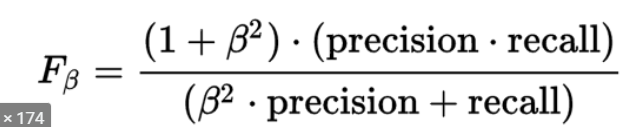

In [112]:
#calculating fbeta score
def fbeta_score(precision, recall, beta):
    nominator = (1 + beta**2) * (precision * recall)
    denominator = (beta**2 * precision) + recall
    
    return nominator / denominator

In [113]:
#calculating fbeta score for all threshold
fbeta =  fbeta_score(precision, recall, 0.5)
fbeta_training = np.max(fbeta)
#returning the threshold of maximum fbeta
best_threshold = threshold[np.argmax(fbeta)]

In [114]:
print(f"best threshold: {best_threshold}")
print(f"f0.5 score = {fbeta_training}")

best threshold: 0.9956845794299515
f0.5 score = 0.9593679458239278


It seemed that the model is confidence in its prediction that anything below 0.996 is predicted as class 0 or "CasualConversation". We shall evaluate if this is true in test set.

# Evaluation of Final Model on Test Set

In [115]:
#returning probability
probability = nb_w2v_model.predict_proba(X_test_vec)[:, 1]

In [116]:
#convert probability to true label
y_pred = pd.Series(['worldnews' if prob >= best_threshold else 'CasualConversation' for prob in probability])

In [117]:
cm = confusion_matrix(y_test_vec, y_pred, labels=['worldnews', 'CasualConversation'])
tp, fn, fp, tn = cm.ravel()

In [118]:
#scoring for test set
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fbeta_test = fbeta_score(precision, recall, 0.5)
pr_auc = average_precision_score(y_test_vec, probability, pos_label='worldnews')

#df for f0.5 scoring of training set vs test set
compare_df = pd.DataFrame( [fbeta_training, fbeta_test], columns=['Fbeta Score Comparison'],
             index=["Training","Test"])

#df for all scoring of  test set
scoring_df = pd.DataFrame( [0.46, pr_auc, fbeta_test, precision, recall, ], columns=['Naives Bayes Word2Vec Score'],
             index=["PR AUC baseline", "PR AUC", "F0.5","Precision", "Recall"])

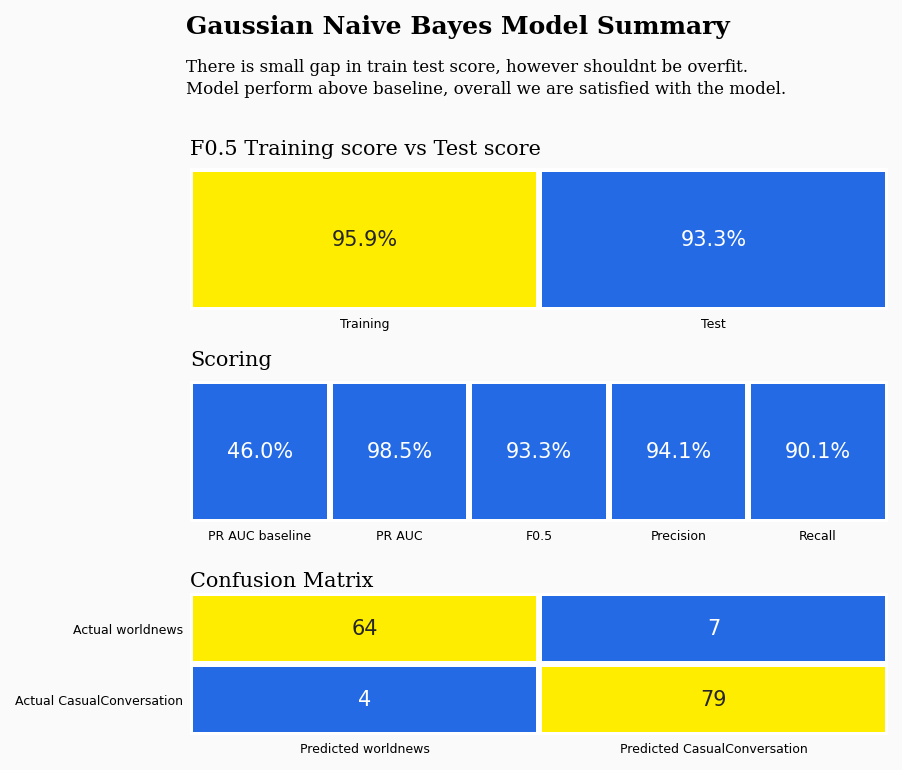

In [119]:
fig = plt.figure(figsize=(6, 5), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.5, hspace=0.5)

#test versus training
ax1 = fig.add_subplot(gs[0, 0])

sns.heatmap(compare_df.T, linewidths=2.5, xticklabels=compare_df.index,
            cmap = [casual, news], cbar=None,annot=True,fmt='.1%',ax=ax1,annot_kws={"fontsize":10})

ax1.tick_params(axis=u'both', which=u'both',length=0, labelsize=6)
ax1.set_yticks([])

ax1.text(0,-0.10,'F0.5 Training score vs Test score ',fontsize=10,fontweight='light',color='black',fontfamily='serif')

#all test scoring
ax2 = fig.add_subplot(gs[1, 0])

sns.heatmap(scoring_df.T, linewidths=2.5, xticklabels=scoring_df.index,
            cmap = [casual], cbar=None,annot=True,fmt='.1%',ax=ax2,annot_kws={"fontsize":10})

ax2.tick_params(axis=u'both', which=u'both',length=0, labelsize=6)
ax2.set_yticks([])
ax2.text(0,-0.11,'Scoring',fontsize=10,fontweight='light',color='black',fontfamily='serif')

#confusion matrix
ax3 = fig.add_subplot(gs[2, 0])

sns.heatmap(cm, linewidths=2.5,yticklabels=['Actual worldnews', 'Actual CasualConversation'], 
            xticklabels=['Predicted worldnews', 'Predicted CasualConversation'],
            cmap = [casual, news], cbar=None,annot=True,fmt='d',ax=ax3,annot_kws={"fontsize":10})

ax3.text(0,-0.1,'Confusion Matrix',fontsize=10,fontweight='light',color='black',fontfamily='serif')
ax3.tick_params(axis=u'both', which=u'both',length=0, labelsize=6)

#title
fig.text(0.12,1.06,'Gaussian Naive Bayes Model Summary ',fontsize=12,fontweight='bold',color='black',fontfamily='serif')
fig.text(0.12,1.01,'There is small gap in train test score, however shouldnt be overfit.',fontsize=8,fontweight='light',color='black',fontfamily='serif')
fig.text(0.12,0.98,'Model perform above baseline, overall we are satisfied with the model.',fontsize=8,fontweight='light',color='black',fontfamily='serif')

plt.show()

# Model Interpretability

Although our model have high accuracy, however we can't 100% trust our model that it is making sensible prediction.

Here is an example of model having high accuracy but the prediction it based on is not sensible.

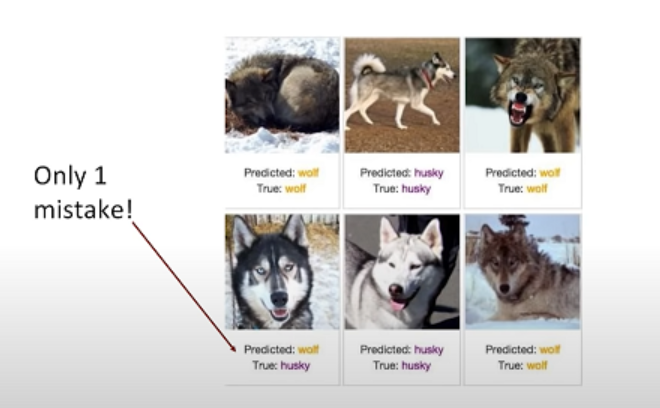

From above picture we can see that the model predicts wolf and husky quite accuracy.

However, we can see that it predicts wolf based on the picture having snow (from the right hand side of each pictures, the part which is not greyed out, is the "feature" which the model used to predicts either wolf/husky) . Hence this model will not generalize if put into production.

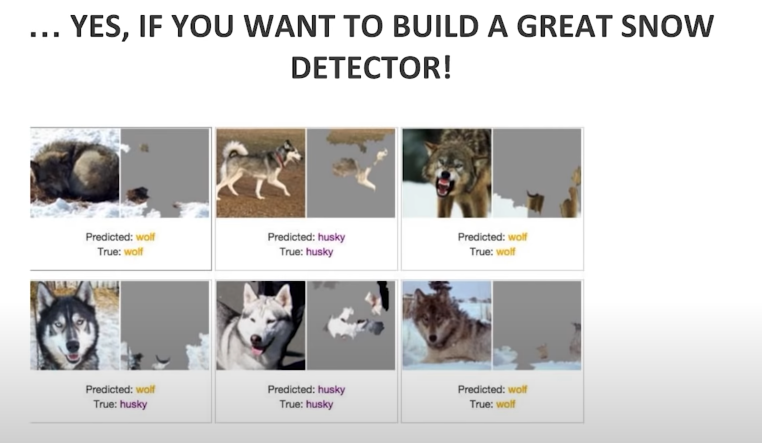

An important part of data science is explaining how our model works.

What are it's strengths & weaknesses?

How does it make decisions?

Here we will use LIME explainer to help answer some of these questions.

## Lime

LIME is model-agnostic, meaning that it can be applied to any machine learning model. The technique attempts to understand the model by perturbing (tweaking) the input of data samples and understanding how the predictions change locally.

In [120]:
#recreate example corpus
list_corpus_v2 = []
for x in reddit_df.token:
    list_corpus_v2.append(" ".join(x))

list_labels = reddit_df.subreddit.tolist()

In [121]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus_v2, list_labels, test_size=0.2, 
                                                                                random_state=40)

In [122]:
vector_store = word2vec

#this function takes in text and embed vectors and return probability.
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, k=300)
        tokenized_list.append(vectorized_example)
    return nb_w2v_model.predict_proba(tokenized_list)

In [123]:
#lime to return an instance of explaination
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

#visualizing lime
def visualize_one_exp(features, labels, index, class_names = ["CasualConversation","WorldNews"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    exp.show_in_notebook(text=True)

### TP Example

In [124]:
# Actual worldnews, Predicted worldnews
visualize_one_exp(X_test_data, y_test_data, 2)

### TN Example

In [125]:
# Actual CasualConversation, Predicted CasualConversation
visualize_one_exp(X_test_data, y_test_data, 13)

### FP Example

In [126]:
# Actual Casual, Predicted WorldNews
visualize_one_exp(X_test_data, y_test_data, 30)

### Where Model Predicted Correctly
Most of the word in the classes where it predicted correctly seemed sensible except for the word **death** in "enjoy roses stage death" i would say think that death will actually occur more in news. However word2vec from the training set has inferred that it is inclined towards casualconversation.

### Where Model predicted Wrongly

It is fairly easy to see why will the model predicted "Japan seem country pop culture US term scope" wrongly. Even as a human, we might think that it is actually from Worldnews given the setences contains "Japan", "US" and "cultures".

Althought this model has made predicted wrongly, the prediction is still sensible  as the text sentence is quite similar to text which will appear in WorldNews. Hence we would have more confidence that this model will generalize.

# Conclusion & Future Recommendation

We have selected the Naive Bayes Model with word2vec pre-processing as the best performing model where it has F0.5 scores of 0.96. We have achieve a metric score significantly higher than our baseline 0.46, and based on the model interpretation we are confidence that it will generalize.

In future, we can add Topic modelling to generate insights of what are the subject being discussed in both subreddits.